# G25293 Image Analysis -- Iris Recognization
> Yifei Xu yx2577

## 0 Data Loading

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [2]:
imgPath ="./CASIA Iris Image Database (version 1.0)/"
img_train_x = []
train_y = []
img_test_x = []
test_y = []

for i in range(1,109,1):
    path1 = "./CASIA Iris Image Database (version 1.0)/"+str(i).zfill(3)+'/'+str(1)+'/'
    for j in [1,2,3]:
        imgFilename = str(i).zfill(3)+"_1_"+str(j)+".bmp"
        img_color = cv2.imread(path1+imgFilename)
        img_RGB = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2GRAY)
        img_train_x.append(img_gray)
        train_y.append(i)

for i in range(1,109,1):
    path2 = "./CASIA Iris Image Database (version 1.0)/"+str(i).zfill(3)+'/'+str(2)+'/'
    for j in [1,2,3,4]:
        imgFilename = str(i).zfill(3)+"_2_"+str(j)+".bmp"
        img_color = cv2.imread(path2+imgFilename)
        img_RGB = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2GRAY)
        img_test_x.append(img_gray)
        test_y.append(i)     

print(len(img_train_x))
print(len(img_test_x))
print(len(train_y))
print(len(test_y))

324
432
324
432


## 1 Image Preprocessing

<img src="./Image_preprocessing.png">

- According to the LiMa's paper, we follow the steps as below:

<img src="./steps.png">

### 1.1 Iris Localization

> __STEPS:__
> - Project the image in the vertical and horizontal direction to approximately estimate the center coordinates $(X_p,Y_p)$ of the pupil. Since the pupil is generally darker than its surroundings, the coordi- nates corresponding to the minima of the two projection profiles are considered as the center coordinates of the pupil.
> - Binarize a $120\times 120$ region centered at the point $(X_p,Y_p)$ by adaptively selecting a reasonable threshold using the gray-level histogram of this region. The centroid of the resulting binary region is considered as a more accurate estimate of the pupil coordinates. In this binary region, we can also roughly compute the radius of the pupil.
> - Calculate the exact parameters of these two circles using __edge detection__ (Canny operator in experiments) and __Hough transform__ in a certain region determined by the center of the pupil.


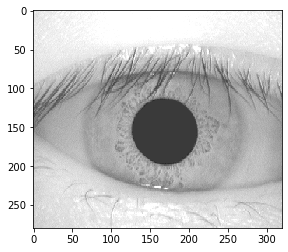

In [39]:
img_gray = img_train_x[65]
plt.imshow(img_color);

In [40]:
m = len(img_gray)
n = len(img_gray[0])
print(m,n)

280 320


- __Edge Detection__

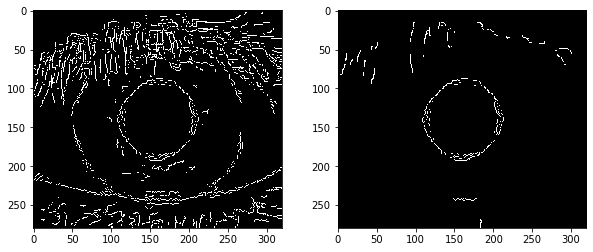

In [41]:
# Create an edge image 
#img_blur = cv2.GaussianBlur(img_gray,(7,7),0)
# Use the Kernel filter to blur the image
img_blur = cv2.blur(img_gray, ksize = (13, 13))
med_val = np.median(img_blur)
lower = int(max(0, .07*med_val))
upper = int(min(255, .13*med_val))
edges1 = cv2.Canny(img_blur, threshold1 = lower, threshold2 = upper)
edges2 = cv2.Canny(img_blur, threshold1 = lower*3, threshold2 = upper*3)

plt.figure(figsize=(10,4));
plt.subplot(121);
plt.imshow(edges1, cmap = 'gray');
plt.subplot(122);
plt.imshow(edges2, cmap = 'gray');

- Find pupil and Iris contour circles through Hough transform

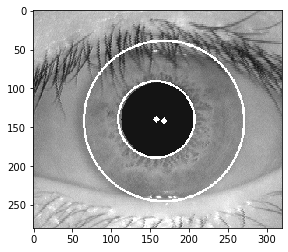

In [42]:
# Hough transform
circle1 = cv2.HoughCircles(edges1, cv2.HOUGH_GRADIENT, 1, 100, param1=100, param2=20, minRadius=80, maxRadius=110)
circle2 = cv2.HoughCircles(edges2, cv2.HOUGH_GRADIENT, 1, 100, param1=100, param2=20, minRadius=30, maxRadius=60)
iris = circle1[0, :, :]
iris = np.uint16(np.around(iris))
pupil = circle2[0, :, :]
pupil = np.uint16(np.around(pupil))
img1 = img_gray.copy()
cv2.circle(img1, (pupil[0][0], pupil[0][1]), pupil[0][2], (255, 0, 0), 2)
cv2.circle(img1, (pupil[0][0], pupil[0][1]), 2, (255, 0, 0), 3)
cv2.circle(img1, (iris[0][0], iris[0][1]), iris[0][2], (255, 0, 0), 2)
cv2.circle(img1, (iris[0][0], iris[0][1]), 2, (255, 0, 0), 3)
plt.imshow(img1, cmap ='gray');

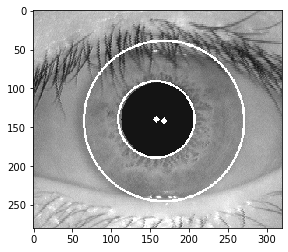

In [43]:
def IrisLocalization(img_gray, img_RGB):
    # Image blur by kernel
    img_blur = cv2.blur(img_gray, ksize = (13, 13))
    
    # Detect the edges
    med_val = np.median(img_blur)
    lower = int(max(0, .07*med_val))
    upper = int(min(255, .13*med_val))
    edges1 = cv2.Canny(img_blur, threshold1 = lower, threshold2 = upper)
    edges2 = cv2.Canny(img_blur, threshold1 = lower*3, threshold2 = upper*3)
    
    # Find the two circles of pupil and iris by Hough transform
    circle1 = cv2.HoughCircles(edges1, cv2.HOUGH_GRADIENT, 1, 100, param1=100, param2=20, minRadius=80, maxRadius=110)
    circle2 = cv2.HoughCircles(edges2, cv2.HOUGH_GRADIENT, 1, 100, param1=100, param2=20, minRadius=30, maxRadius=60)
    iris = circle1[0, :, :]
    iris = np.uint16(np.around(iris))
    pupil = circle2[0, :, :]
    pupil = np.uint16(np.around(pupil))
    
    img1 = img_gray.copy()
    cv2.circle(img1, (pupil[0][0], pupil[0][1]), pupil[0][2], (255, 0, 0), 2)
    cv2.circle(img1, (pupil[0][0], pupil[0][1]), 2, (255, 0, 0), 3)
    cv2.circle(img1, (iris[0][0], iris[0][1]), iris[0][2], (255, 0, 0), 2)
    cv2.circle(img1, (iris[0][0], iris[0][1]), 2, (255, 0, 0), 3)
    
    return pupil, iris, img1

pupil, iris, img2 =  IrisLocalization(img_gray, img_RGB)
plt.imshow(img2, cmap = 'gray');

---
### 1.2 Iris Normalization

<img src="./Rubber_sheet.png">

> We project the original iris in a Cartesian coordinate system into a doubly dimensionless pseudopolar coordinate system. The iris in the new coordinate system can be represented in a fixed parameter interval. That is, this method normalizes irises of different size to the same size. Similar to this scheme, we counterclockwise unwrap the iris ring to a rectangular block with a fixed size. Such unwrapping can be denoted as:

$$
I_n(X,Y) = I_o(x,y)
$$

$$
x = x_p(\theta)+(x_i(\theta)-x_p(\theta))\frac{Y}{M}
$$

$$
y = y_p(\theta)+(y_i(\theta)-y_p(\theta))\frac{Y}{M}
$$

$$
\theta = 2\pi X/N
$$

> where $I_n$ is a $M\times N$ ( $64\times 512$ in our experiments) normalized image, $(x_p(\theta),y_p(\theta))$ and  $(x_i(\theta),y_i(\theta))$ are the coordinates of the inner and outer boundary points in the direction $\theta$ in the original image $I_o$. The normalization not only reduces to a certain extent the iris distortion caused by pupil movement but also simplifies subsequent processing.

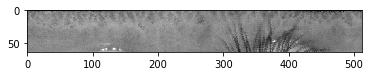

In [45]:
def IrisNormalization(img_gray, pupil, iris):
    M = 64
    N = 512
    rect = np.zeros((M, N))  
    x_p = pupil[0][0]
    y_p = pupil[0][1]
    r_p = pupil[0][2]
    x_i = iris[0][0]
    y_i = iris[0][1]
    r_i = iris[0][2]

    for X in range(N):
        for Y in range(M):
            # Compute theta
            theta = 2*np.pi*X/N
            # Compute the the coordinates of the inner and outer boundary points in the direction theta
            x_pt = x_p + r_p*np.cos(theta)
            y_pt = y_p + r_p*np.sin(theta)
            x_it = x_i + r_i*np.cos(theta)
            y_it = y_i + r_i*np.sin(theta)
            # Compute the coordinate of corresponding point (x,y) in the original image
            x = int(x_pt + (x_it-x_pt)*Y/M)
            y = int(y_pt + (y_it-y_pt)*Y/M)
            # Give the value to (X,Y) in the new image
            rect[Y][X] = img_gray[y][x]
    return rect

rect = IrisNormalization(img_gray, pupil, iris)
plt.imshow(rect, cmap = 'gray');  

---
### 1.3 Image Enhancement

The normalized iris image has __low contrast__ and may have nonuniform brightness caused by the position of light sources. All these may affect the subsequent processing in feature extraction and matching. In order to obtain a more well-distributed texture image, we use the __histogram equalization__ to enhance the image contrast.

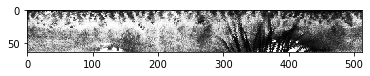

In [46]:
# Use the histogram equalization to enhance the image
def ImageEnhancement(rect,img_gray):
    rect = rect.astype(img_gray.dtype)
    rect_histEqualization = cv2.equalizeHist(rect)
    return rect_histEqualization

rect_histEqualization = ImageEnhancement(rect,img_gray)
plt.imshow(rect_histEqualization, cmap='gray');

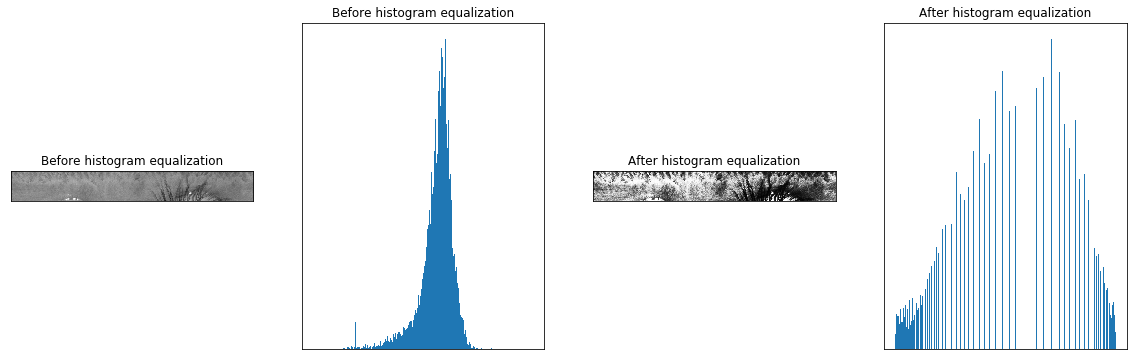

In [47]:
# Plot the comparision
# Plot image before hist equalization and histogram
plt.figure(figsize=(20,6));
plt.figure(1)
plt.subplot(1,4,1) 
plt.imshow(rect, cmap='gray')
plt.title("Before histogram equalization") 
plt.xticks([])
plt.yticks([])
plt.subplot(1,4,2)
plt.hist(rect.ravel(), 256, [0,256])
plt.title("Before histogram equalization")
plt.xticks([])
plt.yticks([])
# Plot image after hist equalization and histogram
plt.subplot(1,4,3) 
plt.imshow(rect_histEqualization, cmap='gray') 
plt.title("After histogram equalization") 
plt.xticks([])
plt.yticks([])
plt.subplot(1,4,4) 
plt.hist(rect_histEqualization.ravel(), 256, [0,256]) 
plt.title("After histogram equalization") 
plt.xticks([])
plt.yticks([]) 
plt.show()

---

## 2 Feature extraction

> The iris has a particularly interesting structure and provides abundant texture information. So, it is desirable to explore representation methods which can capture local underlying information in an iris. From the viewpoint of texture analysis, local __spatial patterns__ in an iris mainly involve __frequency__ and __orientation__ information. Generally, the iris details spread along the radial direction in the original image corresponding to the vertical direction in the normalized image. As a result, the differences of orientation information among irises seem to be not significant. That is, frequency information should account for the major differences of irises from different people. We thus propose a scheme to capture such discriminating frequency information which reflects the local structure of the iris. 

> In general, the majority of useful information of the iris is in a frequency band of about three octaves [18]. Therefore, a bank of filters is constructed to reliably acquire such information in the spatial domain. As we know, coefficients of the filtered image effectively indicate the frequency distribution of an image. Two statistic values are thus extracted from each small region in the filtered image to represent local texture information of the iris. A feature vector is an ordered collection of all features from the local regions. 

### 2.1 Spatial Filters

- Region of Interest: __ROI ( $48 \times 512$ )__ 
> In our experiments, we find that the upper portion of a normalized iris image (corresponding to regions closer to the pupil) provides the most useful texture information for recognition (see Fig. 7). In addition, eyelids and eyelashes rarely occlude this section. So, we extract features only in this section (called region of interest, ROI) shown as the region above the dotted line in Fig. 7. 

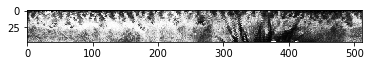

In [48]:
# We only use the ROI (48*512) to do the filtering
rect_roi = rect_histEqualization[0:48,:]
plt.imshow(rect_roi, cmap = 'gray');

- __Defined Filter__(modulated by a circularly symmetric sinusoidal function)

> The kernel is given as follows:

$$
G(x,y,f) = \frac{1}{2\pi \sigma_x \sigma_y}exp[-\frac{1}{2} (\frac{x^2}{\sigma^2_y}+\frac{y^2}{\sigma^2_x})]M_i(x,y,f)
$$

$$
M_1(x,y,f)=cos[2\pi f(\sqrt{x^2+y^2})]
$$

> where $f$ is the frequency of the sinusoidal function, $\sigma_x$ and $\sigma_y$ are the space constants of the Gaussian envelope along the $x$ and $y$ axis, respectively. As mentioned above, useful iris information distributes in a specific frequency range. We therefore use the defined spatial filters in two channels to acquire the most discriminating iris features. $\sigma_x$ and $\sigma_y$ used in the first channel are 3 and 1.5, and the second channel 4.5 and 1.5.

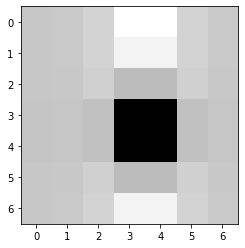

In [49]:
def defined_filter(sigma_x, sigma_y, size, f):
    filt = np.zeros((size,size))
    # size should be an odd number
    k = int((size-1)/2)
    for x in range(-k,k+1,1):
        for y in range(-k,k+1,1):
            M1 = np.cos(2*np.pi*f*np.sqrt(x**2+y**2))
            G = (1/(2*np.pi*sigma_x*sigma_y))*np.exp(x**2/sigma_x**2+y**2/sigma_y**2)*M1
            filt[x,y] = G
    return filt
filt = defined_filter(3, 1.5, 7, 0.07)
plt.imshow(filt, cmap = 'gray')

> According to the above scheme, filtering the ROI ( $48 \times 512$ ) with the defined multichannel spatial filters results in

$$
F_{i}(x,y)=\int\int I(x_{1},y_{1})G_{i}(x-x_{1},y-y_{1})dx_{1}dy_{1};\quad i=1,2
$$

> where $G_i$ is the $i$th channel of the spatial filters, $I(x_{1},y_{1})$ denotes the ROI, and $F_{i}(x,y)$ is the filtered image. To characterize local texture information of the iris, we extract statistical features in each $8\times 8$ small block of the two filtered images. In our experiments, the total number of small blocks is $768[(48\times 512)/(8 \times 8)\times 2]$. For each small block, two feature values are captured. This generates 1,536 feature components. The feature values used in the algorithm are the mean $m$ and the average absolute deviation $\sigma$ of the magnitude of each filtered block defined as

$$
m = \frac{1}{n} \underset{w}{\sum}|F_{i}(x,y)|, \quad \quad \sigma=\frac{1}{n}\underset{w}{\sum}||F_{i}(x,y)|-m|
$$

> where $w$ is an $(8 \times 8)$ block in the filtered image, $n$ is the number of pixels in the block $w$, and $m$ is the mean of the block $w$. These feature values are arranged to form a 1D feature vector

$$
V = [m_1,\sigma_1, m_2, \sigma_2,..., m_{768}, \sigma_{768}]^T
$$

In [50]:
from scipy import ndimage
def feature_extraction(rect_roi):
    filt1 = defined_filter(3, 1.5, 7, 0.07)
    filt2 = defined_filter(4.5, 1.5, 7, 0.07)
    img_filt1 = ndimage.convolve(rect_roi, filt1, mode='wrap')
    img_filt2 = ndimage.convolve(rect_roi, filt1, mode='wrap')
    v = []
    for i in range(64):
        for j in range(6):
            m1 = abs(img_filt1[j*8:j*8+8,i*8:i*8+8]).mean()
            s1 = abs(abs(img_filt1[j*8:j*8+8,i*8:i*8+8])-m).mean()
            m2 = abs(img_filt2[j*8:j*8+8,i*8:i*8+8]).mean()
            s2 = abs(abs(img_filt2[j*8:j*8+8,i*8:i*8+8])-m).mean()
            v.append(m1)
            v.append(s1)
            v.append(m2)
            v.append(s2)
    return v

v = feature_extraction(rect_roi)
len(v)

1536

## 3 Iris Matching

In [ ]:
# Calculate the vectors of all iris images
